In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def plot_graph(validation_data, training_data, graph_type):
    plt.clf()
    epochs = range(1, len(training_data) + 1)
    plt.plot(epochs, training_data, 'r', label='Training '+graph_type)
    plt.plot(epochs, validation_data, 'b', label='Validation '+graph_type)
    plt.title('Training and validation '+graph_type)
    plt.xlabel('Epochs')
    plt.ylabel(graph_type)
    plt.legend()
    plt.show()

In [3]:
data_dir = "./vehicles_images"

In [4]:
batch_size  = 32
img_height = 180
img_width = 180

train_ds = keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                               validation_split=0.2, 
                                                               subset='training',
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

val_ds = keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                               validation_split=0.2, 
                                                               subset='validation',
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)
class_names = train_ds.class_names
print(class_names)

Found 4318 files belonging to 4 classes.
Using 3455 files for training.


2021-12-14 11:18:39.928810: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 4318 files belonging to 4 classes.
Using 863 files for validation.
['bus', 'motorcycle', 'plane', 'train']


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y : (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# pixels value now in range 0,1
print(np.min(first_image), np.max(first_image))

num_classes = 4

0.0010896571 0.9770162


In [6]:
model = Sequential([
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
])
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [7]:
epochs = 15
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/15
108/108 [==============================] - 31s 286ms/step - loss: 1.3314 - accuracy: 0.4072 - val_loss: 1.1237 - val_accuracy: 0.5539
Epoch 2/15
108/108 [==============================] - 30s 276ms/step - loss: 1.0526 - accuracy: 0.5641 - val_loss: 1.0218 - val_accuracy: 0.5689
Epoch 3/15
108/108 [==============================] - 30s 280ms/step - loss: 0.9455 - accuracy: 0.6168 - val_loss: 1.0883 - val_accuracy: 0.5342
Epoch 4/15
108/108 [==============================] - 30s 279ms/step - loss: 0.8006 - accuracy: 0.6932 - val_loss: 1.0453 - val_accuracy: 0.5608
Epoch 5/15
108/108 [==============================] - 30s 281ms/step - loss: 0.6430 - accuracy: 0.7612 - val_loss: 1.1459 - val_accuracy: 0.5469
Epoch 6/15
108/108 [==============================] - 30s 279ms/step - loss: 0.4952 - accuracy: 0.8159 - val_loss: 1.1602 - val_accuracy: 0.5701
Epoch 7/15
108/108 [==============================] - 30s 280ms/step - loss: 0.3526 - accuracy: 0.8787 - val_loss: 1.3716 - val_ac

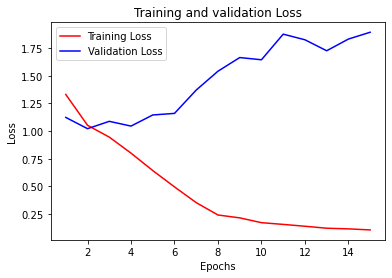

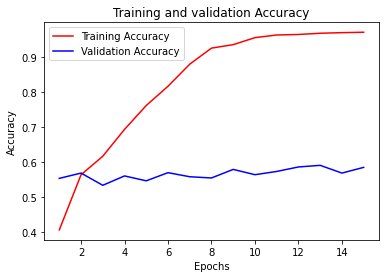

In [8]:
plot_graph(val_loss, loss, 'Loss')
plot_graph(val_acc, acc, 'Accuracy')

In [9]:
model.evaluate(val_ds)

27/27 [==============================] - 2s 80ms/step - loss: 1.8944 - accuracy: 0.5852


[1.8944283723831177, 0.5851680040359497]

In [10]:
img_height

180

#### Overfitting occurred as Validation loss is higher than training loss. Hence need for Data augumentation. Augumentation will help in generating more data by making few changes to the existing image using rotation and flip.

In [11]:
data_augmentation = tf.keras.Sequential([
       tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
       tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [12]:
img_width = 180
img_height = 180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                               validation_split=0.2, 
                                                               subset='training',
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                               validation_split=0.2, 
                                                               subset='validation',
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 4318 files belonging to 4 classes.
Using 3455 files for training.
Found 4318 files belonging to 4 classes.
Using 863 files for validation.


In [13]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(128, activation="relu")(x)
layers.Dense(num_classes)
model1 = keras.Model(inputs=inputs, outputs=outputs)
model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                             

In [14]:
epochs = 15
history = model1.fit(train_ds, validation_data=val_ds, epochs=epochs)
acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']

loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/15
108/108 [==============================] - 45s 410ms/step - loss: 3.2094 - accuracy: 0.3311 - val_loss: 3.0416 - val_accuracy: 0.3917
Epoch 2/15
108/108 [==============================] - 42s 384ms/step - loss: 3.0646 - accuracy: 0.3496 - val_loss: 3.1124 - val_accuracy: 0.3812
Epoch 3/15
108/108 [==============================] - 41s 373ms/step - loss: 3.0447 - accuracy: 0.3589 - val_loss: 3.0672 - val_accuracy: 0.3917
Epoch 4/15
108/108 [==============================] - 41s 379ms/step - loss: 3.0169 - accuracy: 0.3696 - val_loss: 3.0388 - val_accuracy: 0.4114
Epoch 5/15
108/108 [==============================] - 45s 411ms/step - loss: 3.0268 - accuracy: 0.3624 - val_loss: 2.9429 - val_accuracy: 0.4056
Epoch 6/15
108/108 [==============================] - 48s 440ms/step - loss: 2.9811 - accuracy: 0.3826 - val_loss: 2.9694 - val_accuracy: 0.4090
Epoch 7/15
108/108 [==============================] - 41s 374ms/step - loss: 2.9637 - accuracy: 0.3786 - val_loss: 2.9490 - val_ac

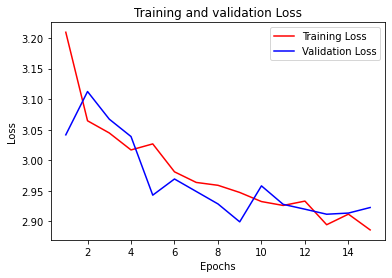

In [15]:
plot_graph(val_loss2, loss2, 'Loss')

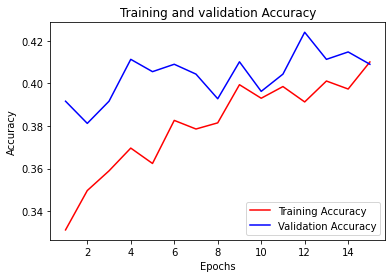

In [16]:
plot_graph(val_acc2, acc2, 'Accuracy')

In [17]:
model1.evaluate(val_ds)

27/27 [==============================] - 3s 110ms/step - loss: 2.9227 - accuracy: 0.4090


[2.922679901123047, 0.409038245677948]

**Feature extraction with pretrained model**

In [18]:
img_width = 160
img_height = 160
IMG_SHAPE = (img_width, img_height) + (3,)

In [19]:
#### Reload the training images because of resizing. Resizing will reduce the memory consumed and thus make the model execute faster

In [20]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                               validation_split=0.2, 
                                                               subset='training',
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                               validation_split=0.2, 
                                                               subset='validation',
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 4318 files belonging to 4 classes.
Using 3455 files for training.
Found 4318 files belonging to 4 classes.
Using 863 files for validation.


In [21]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False,
                                               weights='imagenet')

In [22]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [23]:
base_model.trainable = False
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [24]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [25]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model2 = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model2.summary()

len(model2.trainable_variables)

initial_epochs = 15

loss0, accuracy0 = model2.evaluate(val_ds)
print('initial loss: {:.2f}'.format(loss0))
print('initial accuracy: {:.2f}'.format(accuracy0))

history2 = model2.fit(train_ds, epochs=initial_epochs, validation_data=val_ds)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [26]:
model2.evaluate(val_ds)

27/27 [==============================] - 7s 258ms/step - loss: 0.5045 - accuracy: 0.8192


[0.5044578313827515, 0.8192352056503296]

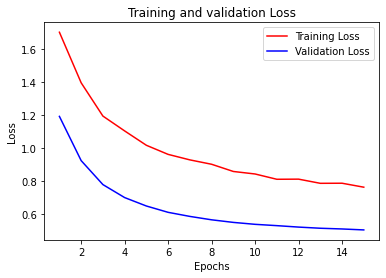

In [27]:
plot_graph(history2.history['val_loss'], history2.history['loss'], 'Loss')

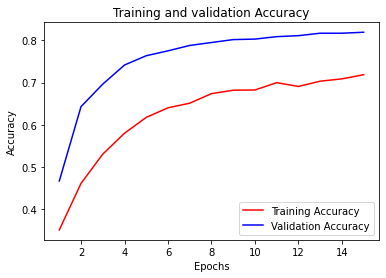

In [28]:
plot_graph(history2.history['val_accuracy'], history2.history['accuracy'], 'Accuracy')

In [29]:
#### Fine tuning model from pretrained model

In [30]:
base_model.trainable = True
base_model.summary()

print('Number of layers in the base model: ',len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [31]:
base_learning_rate = 0.0001
model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
initial_epochs = 15
fine_tune_epochs = 15
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model2.fit(train_ds, epochs=total_epochs, 
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 15/30
108/108 [==============================] - 55s 477ms/step - loss: 0.7104 - accuracy: 0.7294 - val_loss: 0.4983 - val_accuracy: 0.8158
Epoch 16/30
108/108 [==============================] - 52s 479ms/step - loss: 0.6502 - accuracy: 0.7528 - val_loss: 0.4898 - val_accuracy: 0.8227
Epoch 17/30
108/108 [==============================] - 50s 464ms/step - loss: 0.6035 - accuracy: 0.7630 - val_loss: 0.4760 - val_accuracy: 0.8204
Epoch 18/30
108/108 [==============================] - 51s 467ms/step - loss: 0.5907 - accuracy: 0.7725 - val_loss: 0.4656 - val_accuracy: 0.8273
Epoch 19/30
108/108 [==============================] - 50s 465ms/step - loss: 0.5515 - accuracy: 0.7806 - val_loss: 0.4768 - val_accuracy: 0.8262
Epoch 20/30
108/108 [==============================] - 51s 466ms/step - loss: 0.5372 - accuracy: 0.7907 - val_loss: 0.4657 - val_accuracy: 0.8192
Epoch 21/30
108/108 [==============================] - 50s 464ms/step - loss: 0.5137 - accuracy: 0.8009 - val_loss: 0.4712 -

In [33]:
model2.evaluate(val_ds)

27/27 [==============================] - 7s 258ms/step - loss: 0.4834 - accuracy: 0.8239


[0.4833828806877136, 0.8238702416419983]

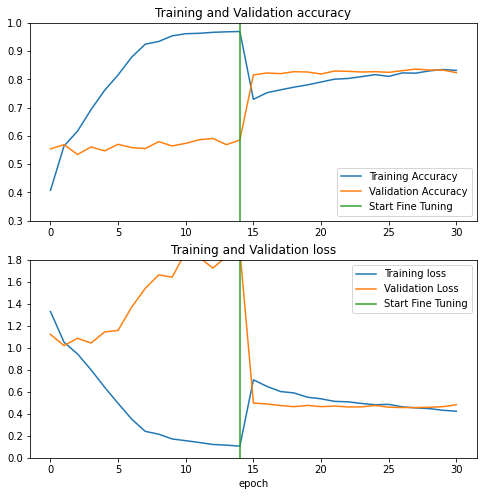

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim(0.3, 1)
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim(0, 1.8)
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.xlabel('epoch')
plt.show()

In [35]:
model2.save('./vehicle-classification', save_format='h5')

/usr/local/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [36]:
saved_model = keras.models.load_model('./vehicle-classification')

In [37]:
#### ['bus', 'motorcycle', 'plane', 'train']

In [38]:
batch_size  = 32
img_height = 160
img_width = 160
test_data = keras.preprocessing.image_dataset_from_directory('./model-test-data/',
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 20 files belonging to 4 classes.


In [39]:
saved_model.evaluate(test_data)

1/1 [==============================] - 1s 968ms/step - loss: 0.2861 - accuracy: 0.9000


[0.28608211874961853, 0.8999999761581421]

In [40]:
def prepareImage(file_path):
    img_array = cv2.imread(file_path)
    new_array = cv2.resize(img_array, (img_width, img_height))
    return new_array.reshape(-1, img_width, img_height, 3, 1)

In [41]:
from keras.preprocessing import image

In [42]:
def predict_images(file_paths):
    test_classes = test_data.class_names
    for path in test_data.file_paths:
        highest_val_index = np.argmax(saved_model.predict(prepareImage(path))[0])
    test_classes = test_data.class_names
    fig = plt.figure(figsize=(20, 20))
    for i, path in enumerate(test_data.file_paths):
        highest_val_index = np.argmax(saved_model.predict(prepareImage(path))[0])
        label=test_classes[highest_val_index]
        img = image.load_img(path, target_size=(img_width,img_height))
        fig.add_subplot(4,5, i+1)
        plt.title(label)
        plt.yticks(color='w')
        plt.xticks(color='w')
        plt.imshow(img)

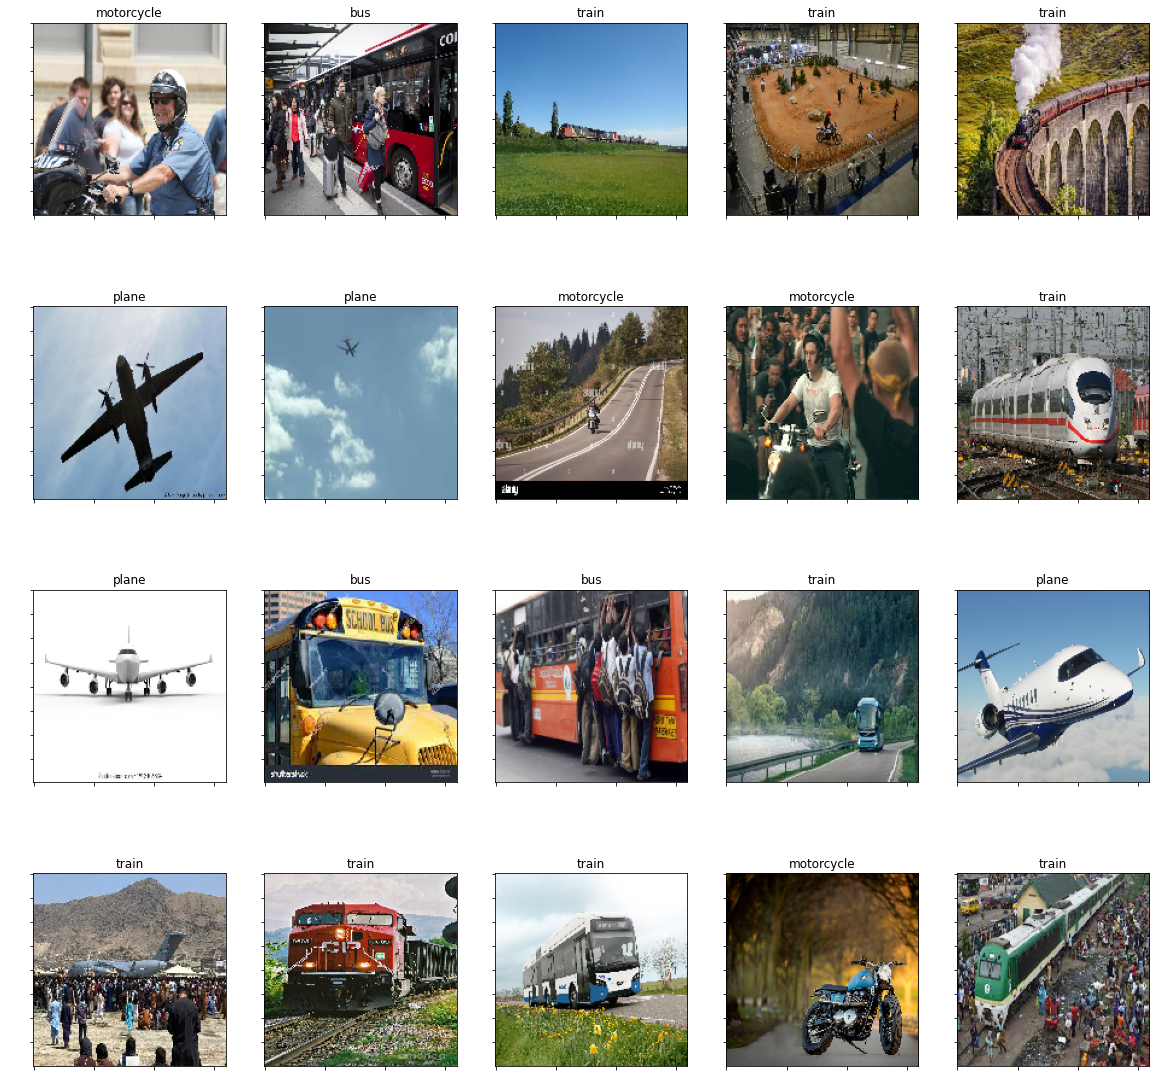

In [43]:
predict_images(test_data.file_paths)